# Best and worst molecules analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error, r2_score
import time

## Uploading data from file

In [2]:
DATA_PATH = "../../../data/4_best_predictions/"
FILE_PATTERN = "dmpnn_with_substr_test.csv"

In [3]:
test = pd.read_csv(DATA_PATH + FILE_PATTERN.format('test'))

In [4]:
compare_data = pd.DataFrame({'smiles': test.smiles, 'y_expected': test.logp, 'y_predicted': test.logp_pred})

In [6]:
X_test_mol = [Chem.MolFromSmiles(x) for x in test.smiles]

In [7]:
y_test = test.logp

## Getting the data to compare

In [8]:
compare_data.head()

,smiles,y_expected,y_predicted
0,CC(=O)NC(Cc1ccccc1)C(=O)NC(Cc1ccccc1)C(=O)N(C)...,2.63,2.439572
1,CC(C)n1c(/C=C/[C@@H](O)C[C@@H](O)CC(=O)O)c(-c2...,4.17,4.146274
2,CCS(=O)c1sc(C(C)=O)c(N)c1C#N,1.82,1.984515
3,O=P(Oc1ccccc1)(Oc1ccccc1)Oc1ccccc1,4.59,3.992221
4,OC1(c2cc(Cl)ccc2Cl)CCCCC1n1cncn1,3.24,3.256713


In [9]:
compare_data.shape

(2067, 3)

In [10]:
compare_data['error'] = (compare_data.y_expected - compare_data.y_predicted) ** 2

In [11]:
compare_data.sort_values(by=['error'], ascending=False).head()

,smiles,y_expected,y_predicted,error
1029,CCCCCCCCCCCCCCP(C)(C)(C)Br,2.06,7.707730,31.896850
1730,O=C(O[K])C1C2CCC(O2)C1C(=O)O[K],0.32,-2.461507,7.736783
1625,CCCC(=NOCC)C1C(=O)CC(C(C)CSCC)CC1=O,1.65,4.421030,7.678608
322,COC(=O)c1sccc1S(=O)(=O)NC(=O)N=c1nc(C)[nH]c(OC)n1,1.56,-0.995996,6.533115
1824,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,-0.21,2.179400,5.709232


In [12]:
compare_data.sort_values(by=['error'], ascending=True).head()

,smiles,y_expected,y_predicted,error
1134,CCCCN(SN(C)C(=O)ON=C(C)SC)C(=O)c1ccccc1,3.40,3.400120,1.431038e-08
1655,COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C,2.30,2.299873,1.607393e-08
459,CCCN=c1[nH]c(SC(F)F)nc(=NCC)[nH]1,3.80,3.799848,2.298650e-08
1264,CCCCc1nccnc1C,2.10,2.100202,4.097143e-08
1301,COC(=O)Nc1ccccc1I,2.44,2.439673,1.068839e-07


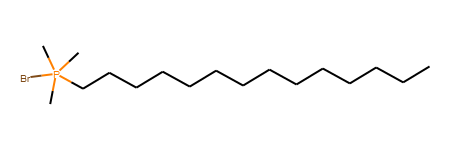

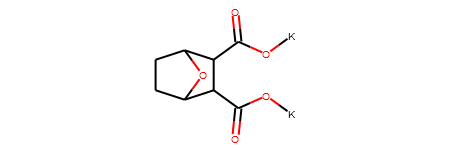

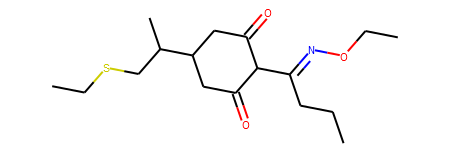

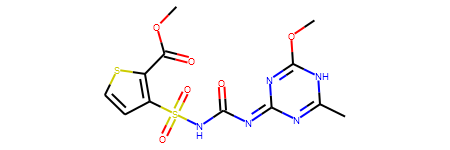

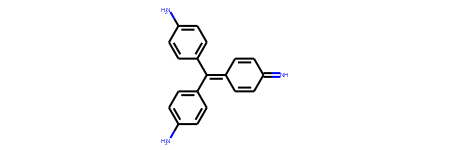

In [13]:
for mol in compare_data.sort_values(by=['error'], ascending=False).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

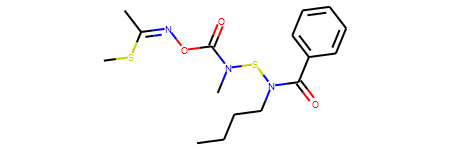

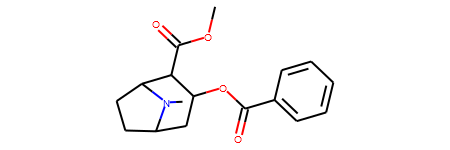

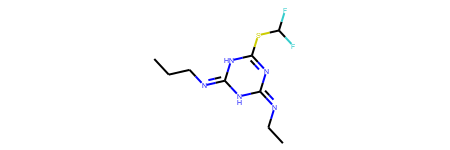

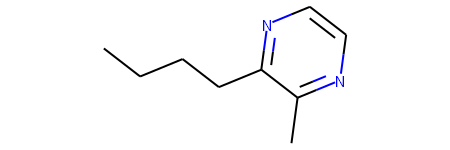

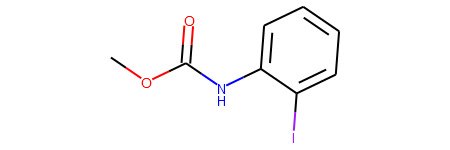

In [14]:
for mol in compare_data.sort_values(by=['error'], ascending=True).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

In [15]:
compare_data = compare_data.sort_values(by=['error'])

## Creating comparing function
### The features to compare:
- The count of atoms
- The count of rings
- The count of not organogens atoms
- The percent of not organogens atoms
- The percent of aromatic (benzene) rings out of all rings
- The count and percent of aromatic bonds
- The symmetry of molecules

In [16]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values.smiles]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [(len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)])) for values in values_list]
    
    return values

## Analyzing the data features

In [17]:
compare_data_with_stats = create_statistics(compare_data)

In [18]:
compare_data_with_stats.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1134,CCCCN(SN(C)C(=O)ON=C(C)SC)C(=O)c1ccccc1,3.40,3.400120,1.431038e-08,20,4,0,0.000000,2,50.0,24,6,25.000000,False
1655,COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C,2.30,2.299873,1.607393e-08,18,1,0,0.000000,1,100.0,24,6,25.000000,False
459,CCCN=c1[nH]c(SC(F)F)nc(=NCC)[nH]1,3.80,3.799848,2.298650e-08,13,2,0,0.000000,1,50.0,17,6,35.294118,False
1264,CCCCc1nccnc1C,2.10,2.100202,4.097143e-08,16,2,3,18.750000,2,100.0,11,6,54.545455,False
1301,COC(=O)Nc1ccccc1I,2.44,2.439673,1.068839e-07,18,1,3,16.666667,1,100.0,12,6,50.000000,False


#### Splitting data into 3 parts

In [19]:
data = []
for i in range(3):
    data.append(compare_data_with_stats.take([j for j in range(i * 1894 // 3, min((i + 1) * 1894 // 3, 1894))]))

In [20]:
data[0].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,6.310000e+02,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.101474,2.099694,3.563897e-03,18.123613,1.808241,0.843106,4.903819,0.955626,54.845672,17.410460,7.630745,45.120756
std,1.549156,1.542728,3.203399e-03,8.381230,1.165508,1.390140,7.967787,0.775372,41.074058,7.899236,4.438819,22.800070
min,-3.170000,-3.262454,1.431038e-08,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,1.080000,1.091725,6.005848e-04,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,33.333333
50%,2.060000,2.059955,2.728412e-03,17.000000,2.000000,0.000000,0.000000,1.000000,50.000000,16.000000,6.000000,46.153846
75%,3.030000,3.020570,6.102969e-03,21.000000,2.000000,1.000000,7.142857,1.000000,100.000000,21.000000,11.000000,60.000000
max,8.160000,8.082201,1.065547e-02,85.000000,8.000000,9.000000,47.058824,4.000000,100.000000,85.000000,26.000000,100.000000


In [21]:
data[1].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,631.000000,631.000000,631.000000,631.00000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.093423,2.108599,0.030999,17.863708,1.863708,0.85103,5.130687,0.966719,56.108596,17.183835,7.245642,43.066593
std,1.694060,1.668056,0.014600,7.920666,1.265086,1.33571,8.266523,0.741407,40.693234,7.176978,4.531534,23.517927
min,-3.400000,-3.583664,0.010731,5.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.990000,1.101824,0.018077,12.500000,1.000000,0.00000,0.000000,0.000000,0.000000,12.000000,6.000000,30.000000
50%,2.030000,2.068214,0.027873,16.000000,2.000000,0.00000,0.000000,1.000000,50.000000,16.000000,6.000000,46.153846
75%,3.050000,3.076059,0.042682,21.000000,2.000000,1.00000,7.692308,1.000000,100.000000,21.000000,11.000000,60.000000
max,8.560000,8.451324,0.062432,66.000000,9.000000,10.00000,66.666667,4.000000,100.000000,65.000000,27.000000,100.000000


In [22]:
data[2].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.00000,632.000000,632.000000,632.000000,632.000000
mean,2.322278,2.301021,0.181488,17.115506,1.740506,0.838608,5.524961,0.90981,54.109403,19.398734,8.036392,42.788542
std,2.036987,1.926737,0.111583,7.068890,1.175181,1.288458,9.609652,0.76767,42.025947,8.995819,5.244598,24.902806
min,-3.200000,-3.823337,0.062746,5.000000,0.000000,0.000000,0.000000,0.00000,0.000000,5.000000,0.000000,0.000000
25%,0.867500,1.035736,0.095557,12.000000,1.000000,0.000000,0.000000,0.00000,0.000000,13.000000,6.000000,27.777778
50%,2.185000,2.174410,0.143991,16.000000,1.000000,0.000000,0.000000,1.00000,50.000000,18.000000,6.000000,42.857143
75%,3.610000,3.589150,0.236160,21.000000,2.000000,1.000000,7.478632,1.00000,100.000000,23.000000,12.000000,60.000000
max,8.600000,8.568897,0.497286,56.000000,7.000000,8.000000,100.000000,5.00000,100.000000,62.000000,30.000000,100.000000


## Check repeting patterns in the middle of the dataset
Hypothesis: badly predicted molecules are symmetric (like 1, 3, 5 worst molecules)

The simplest way to check: take 20 random molecules from the best/middle/worst part.

In [23]:
best = data[0].reset_index().drop(columns=['index'])

In [24]:
best.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,CCCCN(SN(C)C(=O)ON=C(C)SC)C(=O)c1ccccc1,3.40,3.400120,1.431038e-08,20,4,0,0.000000,2,50.0,24,6,25.000000,False
1,COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C,2.30,2.299873,1.607393e-08,18,1,0,0.000000,1,100.0,24,6,25.000000,False
2,CCCN=c1[nH]c(SC(F)F)nc(=NCC)[nH]1,3.80,3.799848,2.298650e-08,13,2,0,0.000000,1,50.0,17,6,35.294118,False
3,CCCCc1nccnc1C,2.10,2.100202,4.097143e-08,16,2,3,18.750000,2,100.0,11,6,54.545455,False
4,COC(=O)Nc1ccccc1I,2.44,2.439673,1.068839e-07,18,1,3,16.666667,1,100.0,12,6,50.000000,False


In [25]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=10))

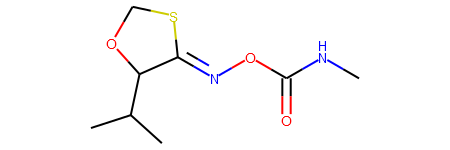

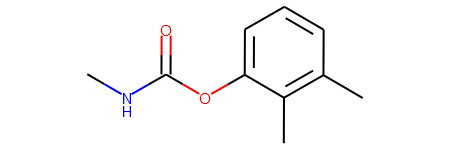

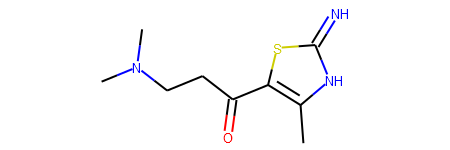

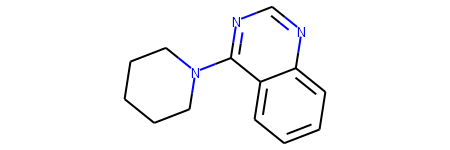

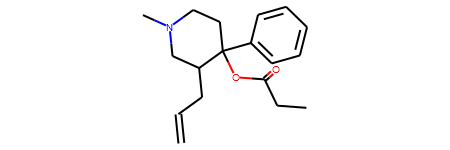

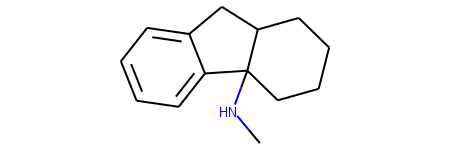

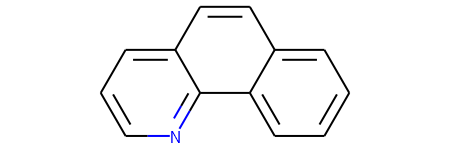

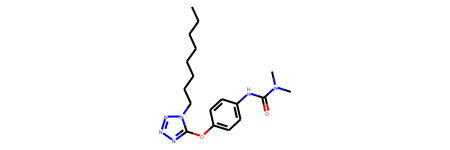

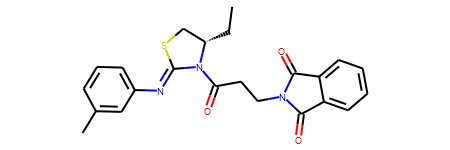

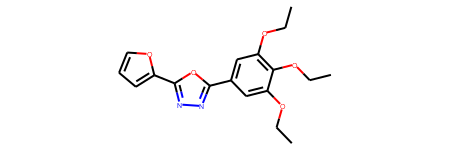

In [26]:
for smiles in best.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [27]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=20))

In [28]:
middle = data[1].reset_index().drop(columns=['index'])

In [29]:
middle.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,NNC(=O)c1cccc(I)c1,1.53,1.426411,0.010731,11,1,0,0.000000,1,100.000000,11,6,54.545455,False
1,C#CCOc1c(Cl)cc(N=CNOC(C)C)cc1Cl,3.90,3.796221,0.010770,17,2,1,5.882353,2,100.000000,19,6,31.578947,False
2,COC(=O)C1(S(=O)(=O)c2ccc(C)cc2)CC1,1.77,1.873805,0.010775,11,1,0,0.000000,1,100.000000,18,6,33.333333,False
3,CCC(C)O,0.61,0.714089,0.010835,12,0,3,25.000000,0,0.000000,4,0,0.000000,False
4,Cc1cc(C(=O)NN)ccn1,-0.37,-0.265855,0.010846,28,3,0,0.000000,1,33.333333,11,6,54.545455,False


In [30]:
middle.shape

(631, 14)

In [31]:
indices = pd.Series(np.random.randint(631, size=10))

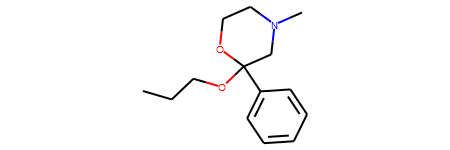

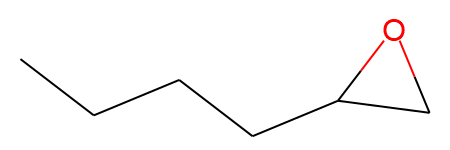

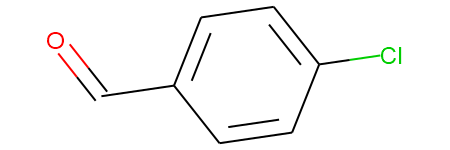

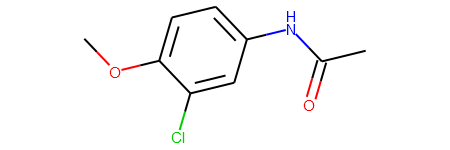

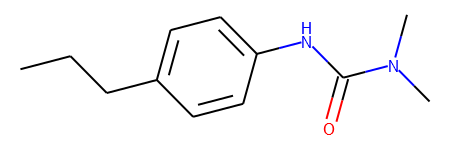

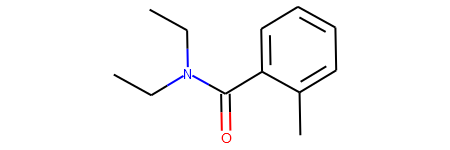

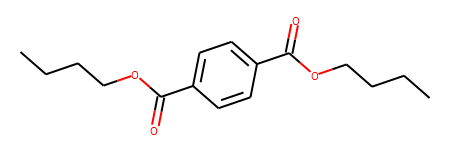

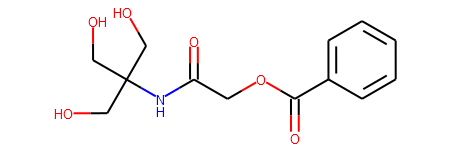

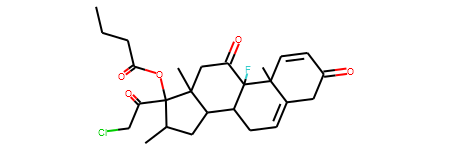

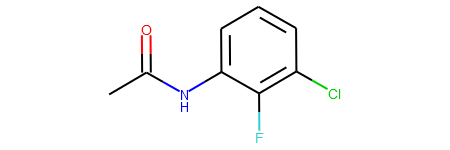

In [32]:
for smiles in middle.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [33]:
worst = data[2].reset_index().drop(columns=['index'])

In [34]:
indices = pd.Series(np.random.randint(631, size=10))

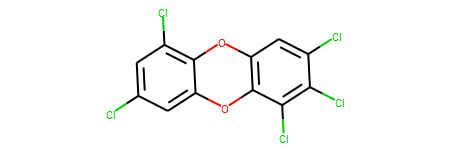

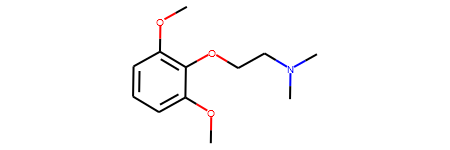

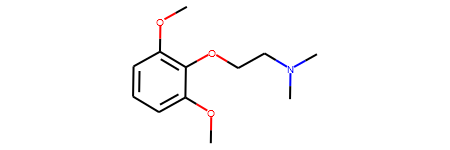

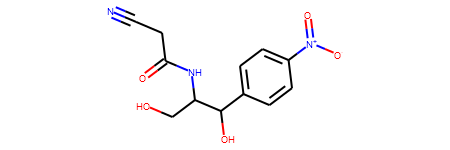

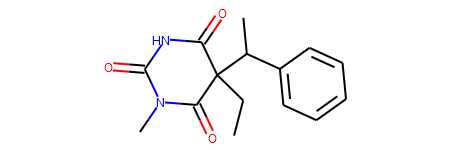

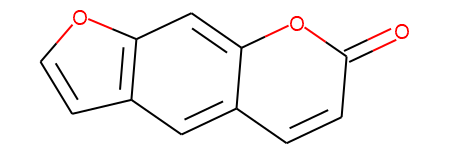

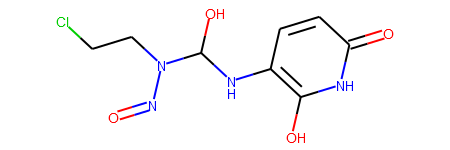

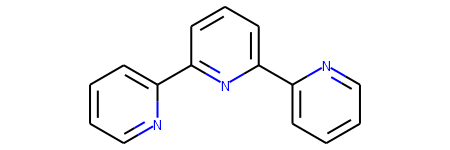

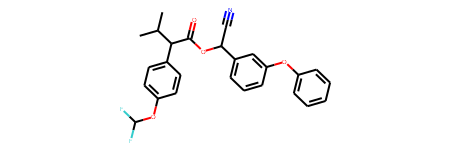

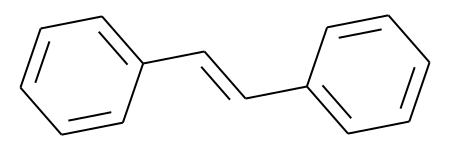

In [35]:
for smiles in worst.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

#### Taking best and worst predicted values

In [36]:
n_values = 200

In [37]:
best_n_vals = compare_data_with_stats.take([j for j in range(n_values)])

In [38]:
worst_n_vals = compare_data_with_stats.take([j for j in range( len(compare_data.smiles) - 1, len(compare_data.smiles) - 1 - n_values, -1)])

In [39]:
best_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1134,CCCCN(SN(C)C(=O)ON=C(C)SC)C(=O)c1ccccc1,3.40,3.400120,1.431038e-08,20,4,0,0.000000,2,50.0,24,6,25.000000,False
1655,COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C,2.30,2.299873,1.607393e-08,18,1,0,0.000000,1,100.0,24,6,25.000000,False
459,CCCN=c1[nH]c(SC(F)F)nc(=NCC)[nH]1,3.80,3.799848,2.298650e-08,13,2,0,0.000000,1,50.0,17,6,35.294118,False
1264,CCCCc1nccnc1C,2.10,2.100202,4.097143e-08,16,2,3,18.750000,2,100.0,11,6,54.545455,False
1301,COC(=O)Nc1ccccc1I,2.44,2.439673,1.068839e-07,18,1,3,16.666667,1,100.0,12,6,50.000000,False


In [40]:
worst_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
1029,CCCCCCCCCCCCCCP(C)(C)(C)Br,2.06,7.707730,31.896850,26,2,0,0.000000,1,50.0,18,0,0.000000,False
1730,O=C(O[K])C1C2CCC(O2)C1C(=O)O[K],0.32,-2.461507,7.736783,14,2,0,0.000000,1,50.0,16,0,0.000000,True
1625,CCCC(=NOCC)C1C(=O)CC(C(C)CSCC)CC1=O,1.65,4.421030,7.678608,19,2,7,36.842105,2,100.0,22,0,0.000000,False
322,COC(=O)c1sccc1S(=O)(=O)NC(=O)N=c1nc(C)[nH]c(OC)n1,1.56,-0.995996,6.533115,14,2,1,7.142857,1,50.0,26,11,42.307692,False
1824,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,-0.21,2.179400,5.709232,23,1,6,26.086957,1,100.0,24,12,50.000000,False


In [41]:
best_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.00000,200.000000,2.000000e+02,200.000000,200.000000,200.0000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2.12980,2.131970,3.249581e-04,18.350000,1.755000,0.7850,4.542507,0.975000,55.658333,17.660000,7.575000,43.325095
std,1.54732,1.545437,2.811605e-04,9.366223,1.100468,1.2676,7.346782,0.759777,40.179628,7.413447,4.446711,22.300441
min,-1.62000,-1.607631,1.431038e-08,6.000000,0.000000,0.0000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,1.20000,1.203033,6.929194e-05,13.000000,1.000000,0.0000,0.000000,0.000000,0.000000,12.750000,6.000000,31.578947
50%,2.01000,2.033922,2.531138e-04,17.000000,2.000000,0.0000,0.000000,1.000000,50.000000,17.000000,6.000000,44.000000
75%,3.18000,3.182196,5.558528e-04,21.000000,2.000000,1.0000,6.666667,1.000000,100.000000,22.000000,11.000000,54.545455
max,6.13000,6.104645,9.511123e-04,85.000000,6.000000,8.0000,40.000000,4.000000,100.000000,51.000000,22.000000,100.000000


In [42]:
worst_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.00000,200.00000,200.000000
mean,2.152450,2.047632,1.332370,17.130000,1.625000,0.990000,6.339792,0.89000,53.166667,23.14000,8.34000,34.610833
std,2.365213,2.224724,2.441884,7.032094,1.039122,1.493672,10.463662,0.74206,42.009145,11.98577,7.21907,23.513519
min,-3.700000,-2.920583,0.436881,5.000000,0.000000,0.000000,0.000000,0.00000,0.000000,4.00000,0.00000,0.000000
25%,0.507500,0.302819,0.559944,12.000000,1.000000,0.000000,0.000000,0.00000,0.000000,14.00000,5.00000,16.250000
50%,2.090000,2.120269,0.751856,16.000000,1.000000,0.000000,0.000000,1.00000,50.000000,21.00000,6.00000,37.980769
75%,3.822500,3.699603,1.361700,21.000000,2.000000,1.000000,8.522727,1.00000,100.000000,29.00000,12.00000,51.753156
max,7.550000,7.707730,31.896850,52.000000,6.000000,7.000000,80.000000,3.00000,100.000000,74.00000,36.00000,85.714286


### Check atom_count influence

In [43]:
print(stats.kruskal(best_n_vals.atom_count, worst_n_vals.atom_count))

KruskalResult(statistic=1.477606658840524, pvalue=0.22414935847886494)


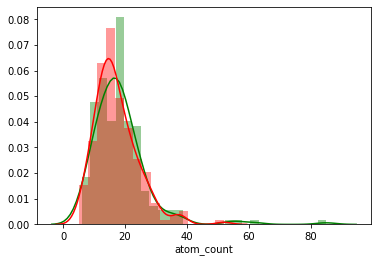

In [44]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

### Check ring_count influence

In [45]:
print(stats.kruskal(best_n_vals.ring_count, worst_n_vals.ring_count))

KruskalResult(statistic=1.4908287045264834, pvalue=0.2220879261730396)


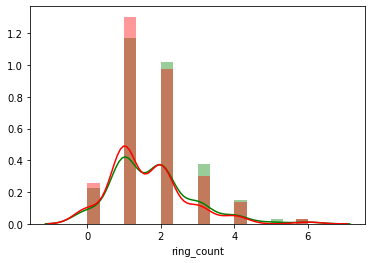

In [46]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

### Check non_organogens_count influence

In [47]:
print(stats.kruskal(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

KruskalResult(statistic=1.3157183856934402, pvalue=0.2513619146077772)


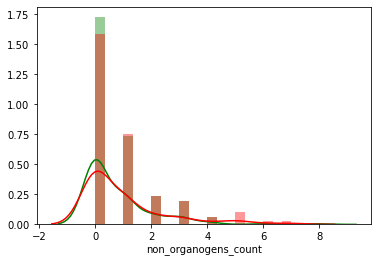

In [48]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

### Check non_organogens_percent influence

In [49]:
print(stats.kruskal(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

KruskalResult(statistic=1.987360187324884, pvalue=0.1586171688686303)


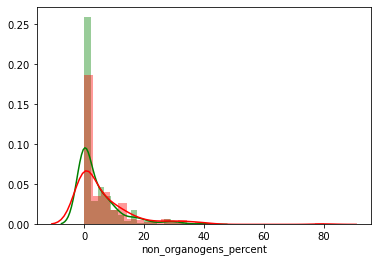

In [50]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

### Check aromatic_count influence

In [51]:
print(stats.kruskal(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

KruskalResult(statistic=1.1598664465785324, pvalue=0.28149323995550474)


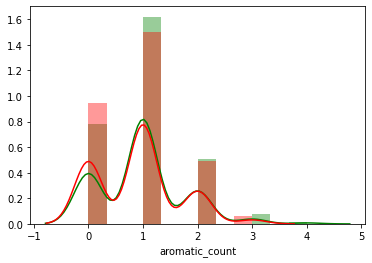

In [52]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

### Check aromatic_rings_percent influence

In [53]:
print(stats.kruskal(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

KruskalResult(statistic=0.34833914322114073, pvalue=0.5550548098296981)


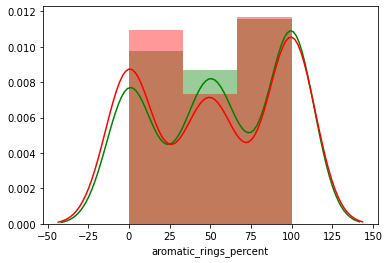

In [54]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')

### Check aromatic bond percent

In [55]:
print(stats.kruskal(best_n_vals.aromatic_bond_percent, worst_n_vals.aromatic_bond_percent))

KruskalResult(statistic=10.809700469746629, pvalue=0.0010096963726081768)


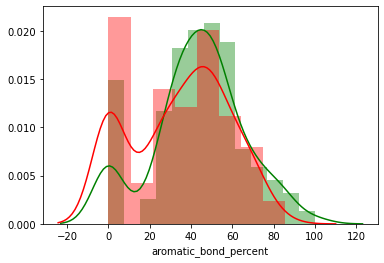

In [56]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

### Check aromatic bond count

In [57]:
print(stats.kruskal(best_n_vals.aromatic_bond_count, worst_n_vals.aromatic_bond_count))

KruskalResult(statistic=0.024310464709544705, pvalue=0.8760975507533957)


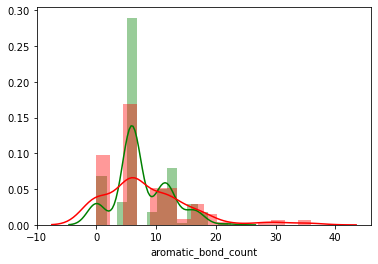

In [58]:
sns.distplot(best_n_vals.aromatic_bond_count, color='g')
sns.distplot(worst_n_vals.aromatic_bond_count, color='r')

### Check symmetric count

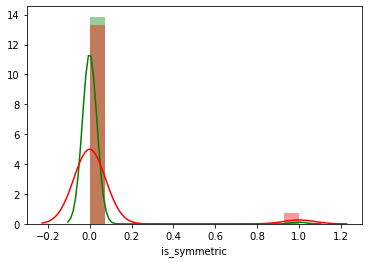

In [59]:
sns.distplot(best_n_vals.is_symmetric, color='g')
sns.distplot(worst_n_vals.is_symmetric, color='r')

### Metrics analysis among symmetric and not symmetric molecules

In [60]:
symmetric_rull = lambda values: (len(values) - 1 <= len(values[values % 2 == 0])) or (len(values) - 1 <= len(values[(values % 2 == 1) & (values > 1)]))

In [61]:
X_test_mol = [Chem.MolFromSmiles(x) for x in compare_data.smiles]

In [62]:
values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in X_test_mol]
symmetric_indices = [symmetric_rull(values) for values in values_list]
not_symmetric_indices = [not e for e in symmetric_indices]

In [63]:
symmetric_y_predicted = compare_data.y_predicted[symmetric_indices]

In [64]:
symmetric_y_expected = compare_data.y_expected[symmetric_indices]

In [65]:
not_symmetric_y_predicted = compare_data.y_predicted[not_symmetric_indices]

In [66]:
not_symmetric_y_expected = compare_data.y_expected[not_symmetric_indices]

In [67]:
print("Test symmetric RMSE =", mean_squared_error(symmetric_y_expected, symmetric_y_predicted, squared=False))
print("Test symmetric R2-score is {0}".format(r2_score(symmetric_y_expected, symmetric_y_predicted)))

Test symmetric RMSE = 0.6452732270506413
Test symmetric R2-score is 0.9214030636108642


In [68]:
print("Test not symmetric RMSE =", mean_squared_error(not_symmetric_y_expected, not_symmetric_y_predicted, squared=False))
print("Test not symmetric R2-score is {0}".format(r2_score(not_symmetric_y_expected, not_symmetric_y_predicted)))

Test not symmetric RMSE = 0.42514304244597617
Test not symmetric R2-score is 0.944685828923484
